### Floating-point sowing and rewards v1.7

This is a refinement of v1.6, making changes in order to get suitable figures for our paper.  Reward function is to be elaborated, and (at least) two different objectives given via reward, so as to demonstrate different trajectories through state space.

(To-do lists below are old and probably deprecated as we move into the new graphical environment.)

The environment now largely conforms to the OpenAI env style, with the env written as a class having a standard set of methods (step, reset, render, close).  AFAICT, making this into a proper OpenAI env means setting up a special directory structure such that it can be loaded and run with the `gym.make()` function---but that isn't nearly as readable as a notebook like this.  The following three cells have the environment and agent code.  

The original (oldest) agent is very dumb; it merely samples from the space of possible action-weight distributions and sows according to the sampled distribution.  Iteration allows it to keep the best distribution it has discovered.  

The newer agent (just below the env code) is slightly smarter.  It takes a biased random walk through weight space, committing to only those steps which produce an increased yield at the end of an episode.  (You can see that, at the moment, it tends toward favoring squash, which in the current reward function provides the highest single-plant reward.)

To-do list for the **environment**:

* try out official OpenAI file + directory structure
* determine the correct gym `space` for the observation space (an *n* x 3 array where the value of *n* isn't fixed until the end of the episode)
* treat plants as enumeration class (maybe? need to make sure attributes like age still available)
* elaborate reward functions and make them more biologically plausible
* * in particular, write something extremely plausible for maize-only planting? (for our beyond-the-row paper)
* update the `render()` code:
* * have one output option be a series of 6 snapshots illustrating an agent's learning
* * another output option for a movie


To-do list for the **agent**:

* write a variety of learning algorithms (to have a bake-off) and wrap them in functions.  most obviously this would include RL algorithms, but shouldn't overlook e.g. quality diversity
* * look at what sklearn has to offer
* currently the only thing the agent can observe is the .field property, which is the location and species of each plant.  add a separate .state property of the environment with additional features to observe?  for example, the ages of each plant


In [ ]:
#shannon and jordan edits
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import error, spaces, utils
from gym.utils import seeding
from enum import Enum

class Plant:
    def __init__(self, species, maturity=110):
        self.species = species
        self.maturity = maturity         # consider 'days_to_maturity'
        self.age = 0
        
    def __repr__(self):
        return "{}".format(self.species)
    

class Field(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, size=5, sow_limit=200, season=120, calendar=0):
        # parameters for overall field character
        self.size = size
        self.sow_limit = sow_limit
        self.season = season
        self.calendar = calendar
        
        # constants for computing end-of-season reward---distances represent meters
        self.crowding_dist = .02
        self.maize_maize_dist = .1
        self.bean_support_dist = .1
        self.crowding_penalty = .1
        self.maize_maize_penalty = .9
        self.bean_support_bonus = .6
        
        # OpenAI action and observation space specifications
        self.action_space = spaces.Discrete(4)
        ### self.observation_space = spaces.???
        
        # field is initialized by calling reset()
        self.field = None
        
    def step(self, action):
        # sow plants (or wait) depending on actions chosen
        # action is an array of n choices; value of n specified in agent code sow_limit
        # could be cleaned up with plants as an enumeration?
        
        for choice in action:
            if choice == 0:
                self.field = np.append(self.field, [[self.size * np.random.random(), 
                                             self.size * np.random.random(), 
                                             Plant('Maize')]], axis=0)
            elif choice == 1:
                self.field = np.append(self.field, [[self.size * np.random.random(), 
                                             self.size * np.random.random(), 
                                             Plant('Bean')]], axis=0)
            elif choice == 2:
                self.field = np.append(self.field, [[self.size * np.random.random(), 
                                             self.size * np.random.random(), 
                                             Plant('Squash')]], axis=0)
            # when choice == 3, nothing is done (agent waits)   
            
        
        # increment timekeeping
        self.calendar +=1
        for plant in self.field:
            plant[2].age += 1
            
        done = self.calendar == self.season
            
        if not done:
            reward = 0
        else:
            reward = self.get_reward()
            
        return self.field, reward, done, {}
    
    def reset(self):
        # field is initialized with one random corn plant in order to make sowing (by np.append) work
        self.field = np.array([[self.size * np.random.random(), 
                                self.size * np.random.random(), 
                                Plant('Maize')]])
        # timekeeping is reset
        self.calendar = 0
        
    def render(self, mode='human'):
        # initialize plant type arrays so that pyplot won't break if any is empty
        maize = np.array([[None, None]])
        bean = np.array([[None, None]])
        squash = np.array([[None, None]])
        maize_imm = np.array([[None, None]])
        bean_imm = np.array([[None, None]])
        squash_imm = np.array([[None, None]])
        
        # replace initial arrays with coordinates for each plant type
        maize = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Maize' and row[2].age >= row[2].maturity])
        bean = np.array([row for row in self.field 
                            if row[2].__repr__() == 'Bean' and row[2].age >= row[2].maturity])
        squash = np.array([row for row in self.field 
                              if row[2].__repr__() == 'Squash' and row[2].age >= row[2].maturity])
        maize_imm = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Maize' and row[2].age < row[2].maturity])
        bean_imm = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Bean' and row[2].age < row[2].maturity])
        squash_imm = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Squash' and row[2].age < row[2].maturity])
        
        # plot the field---currently breaks if any plant type is absent
        plt.figure(figsize=(10, 10))
        #print(maize)
        #print(bean)
        #print(squash)
        plt.scatter(maize[:,0], maize[:,1], c='green', s=200, marker = 'o', alpha=.5, edgecolor='#303030')
        plt.scatter(bean[:,0], bean[:,1], c='brown', s=150, marker = 'o', alpha=.5, edgecolor='#303030')
        plt.scatter(squash[:,0], squash[:,1], c='orange', s=400, marker = 'o', alpha=.5, edgecolor='#303030')
        plt.scatter(maize_imm[:,0], maize_imm[:,1], c='green', s=200, marker = 'o', alpha=.1, edgecolor='#303030')
        plt.scatter(bean_imm[:,0], bean_imm[:,1], c='brown', s=200, marker = 'o', alpha=.1, edgecolor='#303030')
        plt.scatter(squash_imm[:,0], squash_imm[:,1], c='orange', s=200, marker = 'o', alpha=.1, edgecolor='#303030')

        plt.show()
        
        print("Total yield in Calories is {}.\n---\n".format(round(reward, 1)))
    
    def close(self):
        # unneeded right now? AFAICT this is only used to shut down realtime movie visualizations
        pass
    
    def get_reward(self):
        # array of plant coordinates for computing distances
        xy_array = np.array([[row[0], row[1]] for row in self.field])

        # distances[m,n] is distance from mth to nth plant in field
        distances = np.linalg.norm(xy_array - xy_array[:,None], axis=-1)
        
        reward = 0
        i = 0
        while i < len(self.field):
            if self.field[i,2].age < self.field[i,2].maturity:
                reward += 0
            elif self.field[i,2].__repr__() == 'Maize':
                cal = 1
                j = 0
                while j < len(distances[0]):
                    if (self.field[j,2].__repr__() == 'Bean' 
                            and distances[i,j] < self.bean_support_dist):
                        cal += self.bean_support_bonus
                    if (self.field[j,2].__repr__() == 'Maize' 
                            and i !=j 
                            and distances[i,j] < self.maize_maize_dist):
                        cal *= self.maize_maize_penalty
                    if 0 < distances[i,j] < self.crowding_dist:
                        cal *= self.crowding_penalty
                    j += 1
                reward += cal
            elif self.field[i,2].__repr__() == 'Bean':
                reward += .25
            elif self.field[i,2].__repr__() == 'Squash':
                reward += 3
            i += 1        
        return reward


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import error, spaces, utils
from gym.utils import seeding
from enum import Enum

class Plant:
    def __init__(self, species, maturity=110):
        #self.species = species
        self.maturity = maturity         # consider 'days_to_maturity'
        self.age = 0
        
    def __repr__(self):
        return "{}".format(self.species)

class Maize(Plant):
    # add specs here --> maybe cost?
    def __init__():
        pass

class Field(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, size=5, sow_limit=200, season=120, calendar=0):
        # parameters for overall field character
        self.size = size
        self.sow_limit = sow_limit
        self.season = season
        self.calendar = calendar
        self.budget = 200 
        # constants for computing end-of-season reward---distances represent meters
        self.crowding_dist = .02
        self.maize_maize_dist = .1
        self.bean_support_dist = .1
        self.crowding_penalty = .1
        self.maize_maize_penalty = .9
        self.bean_support_bonus = .6
        self.plant_cost = 0.01 # adding cost -- must define plant class if we want variable cost 
        
        # OpenAI action and observation space specifications
        self.action_space = spaces.Discrete(4)
        ### self.observation_space = spaces.???
        
        # field is initialized by calling reset()
        self.field = None
        
    def step(self, action):
        # sow plants (or wait) depending on actions chosen
        # action is an array of n choices; value of n specified in agent code sow_limit
        # could be cleaned up with plants as an enumeration?
        
        for choice in action:
            if choice == 0:
                self.field = np.append(self.field, [[self.size * np.random.random(), 
                                             self.size * np.random.random(), 
                                             Plant('Maize')]], axis=0)
            elif choice == 1:
                self.field = np.append(self.field, [[self.size * np.random.random(), 
                                             self.size * np.random.random(), 
                                             Plant('Bean')]], axis=0)
            elif choice == 2:
                self.field = np.append(self.field, [[self.size * np.random.random(), 
                                             self.size * np.random.random(), 
                                             Plant('Squash')]], axis=0)
            # when choice == 3, nothing is done (agent waits)   
            
        
        # increment timekeeping
        self.calendar +=1
        for plant in self.field:
            plant[2].age += 1
            
        done = self.calendar == self.season
            
        if not done:
            reward = 0
        else:
            reward = self.get_reward()
            
        return self.field, reward, done, {}
    
    def reset(self):
        # field is initialized with one random corn plant in order to make sowing (by np.append) work
        self.field = np.array([[self.size * np.random.random(), 
                                self.size * np.random.random(), 
                                Plant('Maize')]])
        # timekeeping is reset
        self.calendar = 0
        
    def render(self, mode='human'):
        # initialize plant type arrays so that pyplot won't break if any is empty
        maize = np.array([[None, None]])
        bean = np.array([[None, None]])
        squash = np.array([[None, None]])
        maize_imm = np.array([[None, None]])
        bean_imm = np.array([[None, None]])
        squash_imm = np.array([[None, None]])
        
        # replace initial arrays with coordinates for each plant type
        maize = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Maize' and row[2].age >= row[2].maturity])
        bean = np.array([row for row in self.field 
                            if row[2].__repr__() == 'Bean' and row[2].age >= row[2].maturity])
        squash = np.array([row for row in self.field 
                              if row[2].__repr__() == 'Squash' and row[2].age >= row[2].maturity])
        maize_imm = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Maize' and row[2].age < row[2].maturity])
        bean_imm = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Bean' and row[2].age < row[2].maturity])
        squash_imm = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Squash' and row[2].age < row[2].maturity])
        
        # plot the field---currently breaks if any plant type is absent
        plt.figure(figsize=(10, 10))
        #print(maize)
        #print(bean)
        #print(squash)
        plt.scatter(maize[:,0], maize[:,1], c='green', s=200, marker = 'o', alpha=.5, edgecolor='#303030')
        plt.scatter(bean[:,0], bean[:,1], c='brown', s=150, marker = 'o', alpha=.5, edgecolor='#303030')
        plt.scatter(squash[:,0], squash[:,1], c='orange', s=400, marker = 'o', alpha=.5, edgecolor='#303030')
        plt.scatter(maize_imm[:,0], maize_imm[:,1], c='green', s=200, marker = 'o', alpha=.1, edgecolor='#303030')
        plt.scatter(bean_imm[:,0], bean_imm[:,1], c='brown', s=200, marker = 'o', alpha=.1, edgecolor='#303030')
        plt.scatter(squash_imm[:,0], squash_imm[:,1], c='orange', s=200, marker = 'o', alpha=.1, edgecolor='#303030')

        plt.show()
        
        print("Total yield in Calories is {}.\n---\n".format(round(reward, 1)))
    
    def close(self):
        # unneeded right now? AFAICT this is only used to shut down realtime movie visualizations
        pass
    
    def get_reward(self):
        # array of plant coordinates for computing distances
        xy_array = np.array([[row[0], row[1]] for row in self.field])

        # distances[m,n] is distance from mth to nth plant in field
        distances = np.linalg.norm(xy_array - xy_array[:,None], axis=-1)
        
        reward = 0
        i = 0
        while i < len(self.field):
            if self.field[i,2].age < self.field[i,2].maturity:
                reward += 0
            elif self.field[i,2].__repr__() == 'Maize':
                cal = 1
                j = 0
                while j < len(distances[0]):
                    if (self.field[j,2].__repr__() == 'Bean' 
                            and distances[i,j] < self.bean_support_dist):
                        cal += self.bean_support_bonus
                    if (self.field[j,2].__repr__() == 'Maize' 
                            and i !=j 
                            and distances[i,j] < self.maize_maize_dist):
                        cal *= self.maize_maize_penalty
                    if 0 < distances[i,j] < self.crowding_dist:
                        cal *= self.crowding_penalty
                    j += 1
                reward += cal
            elif self.field[i,2].__repr__() == 'Bean':
                reward += .25
            elif self.field[i,2].__repr__() == 'Squash':
                reward += 3
            
            i += 1        
        # cost
            reward -= self.plant_cost*len(self.field)
        # diversity index https://en.wikipedia.org/wiki/Fairness_measure
        return reward


Results after 0 trials:
[[2.74989699742679 4.5165307033068265 Maize]
 [1.772295051903553 1.9864935848583642 Maize]
 [3.2711384353656814 4.216522949261684 Maize]
 [4.598694767550003 3.165907670674966 Maize]
 [2.505573202581721 4.235374577825454 Maize]
 [3.216534033175002 4.217680162437113 Maize]
 [0.33816938206094105 0.3687936587476004 Maize]
 [0.5510807931913209 0.8658168478328554 Maize]
 [0.4141984559380679 1.6010822964518185 Maize]
 [1.2176725557713786 4.796574150055848 Maize]
 [2.855424034761721 3.7457166401570396 Maize]
 [0.9847411914649218 2.235049667690099 Maize]
 [1.6741391487043948 4.9800632415070485 Maize]
 [2.7452558377661784 1.3007773226823471 Maize]
 [2.6951272862840083 4.96670671280644 Maize]
 [3.049133157827251 0.8517528012097386 Maize]
 [3.1661771638843876 4.549865230545843 Maize]
 [3.1647784867106217 0.41278003038817457 Maize]
 [0.47610879382507354 0.5326837332633833 Maize]
 [4.3579748171110095 0.015178956100631025 Maize]
 [4.3113285520155396 2.3340853460062223 Maize]
 

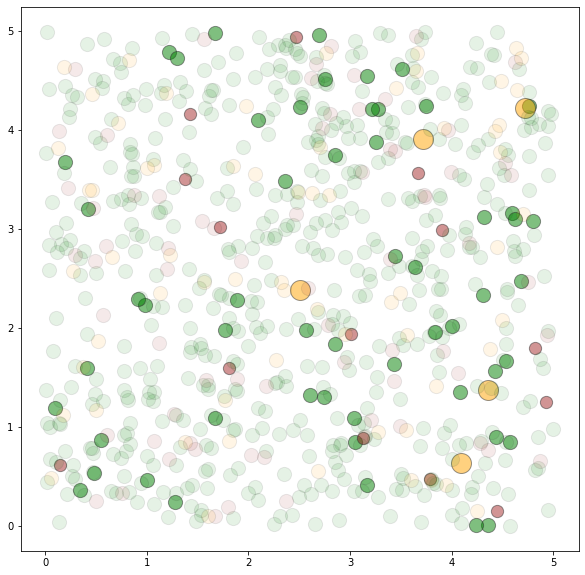

Total yield in Calories is 70.4.
---

Results after 20 trials:
[[0.38595918962569753 1.218222860648378 Maize]
 [4.384755221581013 3.6497417768733937 Maize]
 [3.323821916579253 4.28627516828087 Maize]
 [4.208677179757551 3.911656342278373 Maize]
 [1.9813765183873273 2.2016259841083867 Maize]
 [0.26946303907252 1.8311762879106552 Maize]
 [4.208608995205319 1.5993958509053914 Maize]
 [3.67093251373503 1.4614562902978323 Maize]
 [3.333958923053647 0.806655891712682 Maize]
 [4.313629635881189 4.561578172755814 Maize]
 [3.2468809897501894 2.8736652241015643 Maize]
 [4.897784390892107 0.20169274667874326 Maize]
 [1.864485148032406 1.2770555951215834 Maize]
 [2.44432627178088 4.986673213552455 Maize]
 [3.2105014902623887 4.19767683291426 Maize]
 [0.7024733832156976 0.2674219090541613 Maize]
 [1.9719399329065412 0.3143001791112765 Maize]
 [0.7704045860426562 2.7282553803192218 Maize]
 [4.310583720249196 4.661114297556314 Maize]
 [3.2640958141127747 3.6417066205552286 Maize]
 [4.327903944573968 

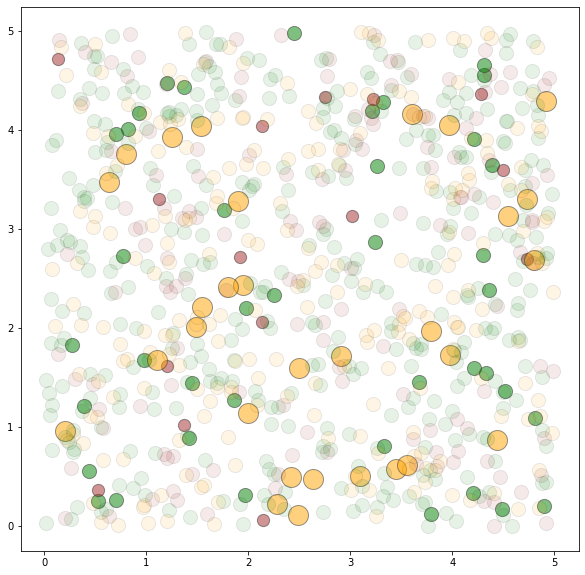

Total yield in Calories is 133.2.
---

Results after 40 trials:
[[2.6607620300173744 1.65432610935532 Maize]
 [1.4741161008080383 1.8478325188355886 Maize]
 [1.890537143028217 3.251514556369488 Maize]
 [2.9812708046792054 1.1199927209467986 Maize]
 [0.12808987318981446 0.3137120065986543 Maize]
 [3.062212291171188 4.596372938209047 Maize]
 [1.5656875114681035 1.6658552298099483 Maize]
 [1.7001911028574301 0.12812414959694984 Maize]
 [2.1244497605640684 1.628977070016825 Maize]
 [2.029168923949529 1.8893180345598781 Maize]
 [1.9122022465431594 0.852333764386552 Maize]
 [3.626528452079061 1.6163557649604159 Maize]
 [1.9169605440340376 4.239698888940495 Maize]
 [4.839917506612449 4.570406547436345 Maize]
 [3.765983036143518 4.3412255548475756 Maize]
 [0.34927178407095194 4.062035859271305 Maize]
 [1.5591470571674038 2.9410924716540205 Maize]
 [3.7782486592917905 3.9572923337950834 Maize]
 [0.08807871100569131 1.279436046908904 Maize]
 [3.460239439951806 2.022734557973569 Maize]
 [2.611975

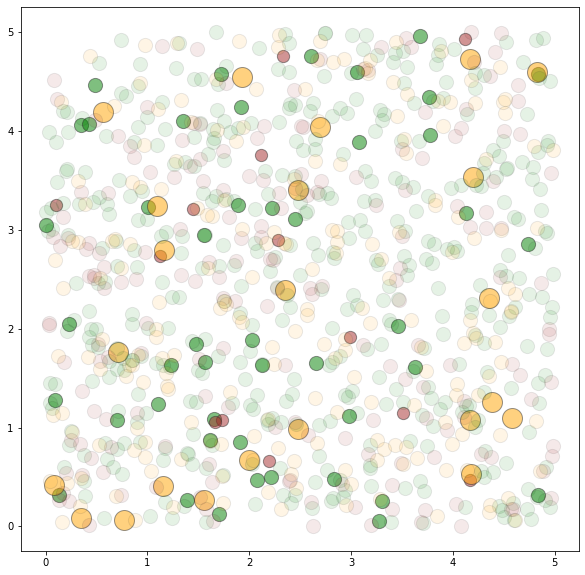

Total yield in Calories is 119.8.
---

Results after 60 trials:
[[1.7960365727470133 0.950525203672839 Maize]
 [1.3184196794138248 3.4117702816475988 Maize]
 [1.3032211160801377 4.338650604415955 Maize]
 [3.863864900276663 0.0023512425901878187 Maize]
 [4.320506005499723 1.5204715337861552 Maize]
 [1.5360228861697238 1.6975984228664254 Maize]
 [1.2001369068664336 4.2572866189557566 Maize]
 [3.9521457712768426 3.1427886379264205 Maize]
 [4.533965812470427 1.9137753170322287 Maize]
 [2.8099764904848223 2.9511023308799085 Maize]
 [2.5312345614228136 1.6851945622133973 Maize]
 [0.13388319704375373 3.756178488638251 Maize]
 [1.2680446077275742 4.3782208200798 Maize]
 [0.2626022657145105 1.548759580189567 Maize]
 [1.0861330981338146 1.3487646709003376 Maize]
 [4.891497274469559 1.5195598965915909 Maize]
 [3.5462473809017974 4.4207608352078545 Maize]
 [2.728295419967593 4.736907807423129 Maize]
 [4.977668323620593 3.2281058395369184 Maize]
 [2.4968966922912927 0.4105074295781602 Maize]
 [3.72

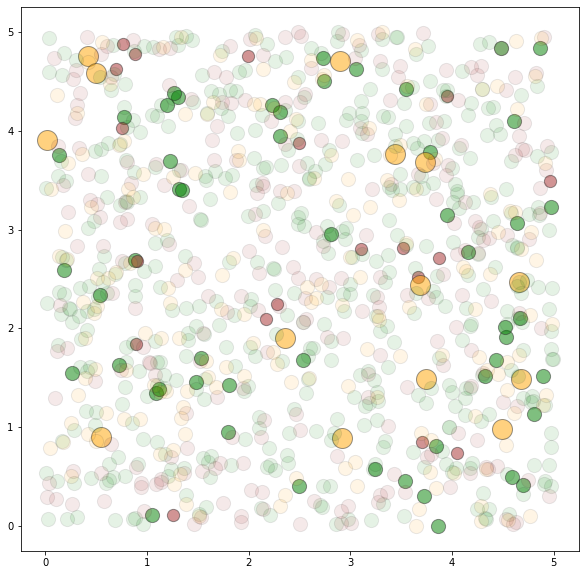

Total yield in Calories is 101.7.
---

Results after 80 trials:
[[0.45841713587553623 3.2365959549532777 Maize]
 [1.4861017776687486 2.545706383382048 Maize]
 [2.8457081233257275 2.7516430899005115 Maize]
 [3.027085655899776 1.5514189939822143 Maize]
 [2.64485683952187 2.573048990676991 Maize]
 [3.683118686884139 0.10297236026143519 Maize]
 [1.4386727376686659 2.0989284558443364 Maize]
 [3.810108883157601 1.2314666367854232 Maize]
 [0.776200067963318 3.0930361525727506 Maize]
 [4.246401664946729 3.6986275721082063 Maize]
 [2.1112710666896333 2.586458605741969 Maize]
 [3.154928457840943 0.9539493167290258 Maize]
 [0.014968199957712258 2.7014328863721953 Maize]
 [4.9636226349478845 3.6910407496751194 Maize]
 [0.46825472866954543 0.41515276149486025 Maize]
 [4.809912977127058 2.6901284878753144 Maize]
 [2.383221255968919 0.7542295504082225 Maize]
 [3.1126629663741125 3.20102926465139 Maize]
 [2.4624123976196937 0.5032484837162504 Maize]
 [2.7862614358912916 4.127760521044483 Maize]
 [4.60

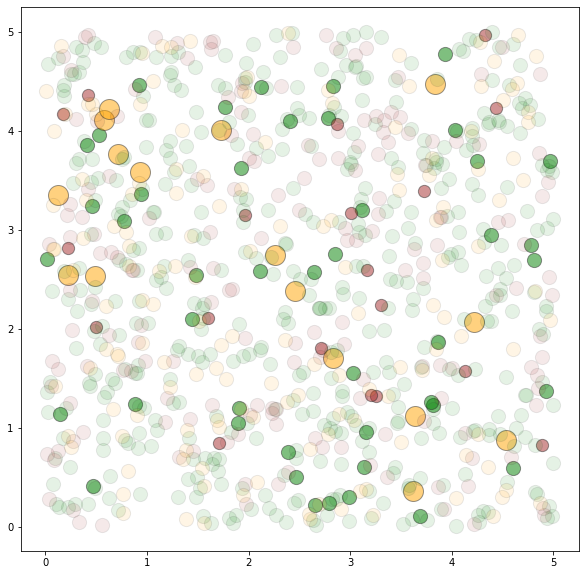

Total yield in Calories is 96.6.
---

Results after 100 trials:
Best weights discovered are: 
	sow maize 	0.3243101012427955 
	sow bean 	0.20596657680721708 
	sow squash 	0.25687622252078707        
	wait 		0.21284709942920038
[[4.794145299624619 0.23184122889927938 Maize]
 [1.0079560504902818 1.9017338257601941 Maize]
 [0.8050474258707246 0.8492657697705203 Maize]
 [1.2347012855523787 4.385637836714002 Maize]
 [2.1312014212130355 3.2043675298391268 Maize]
 [1.331816043475228 2.6028679586448837 Maize]
 [2.6572196646991566 2.62240568619609 Maize]
 [2.5270826920872826 4.735604254368032 Maize]
 [3.2875125788345505 3.701434757478924 Maize]
 [2.0158883539285033 0.6105379913531683 Maize]
 [4.370377188808156 2.2550646042798164 Maize]
 [0.37244504241751186 2.2852807477835557 Maize]
 [2.834313508011947 4.371885708855588 Maize]
 [3.971846001183227 0.7996860722762 Maize]
 [3.1399285138811823 0.28268559877060007 Maize]
 [3.246581075057531 2.5499167326494456 Maize]
 [4.704791818849867 3.12564953661

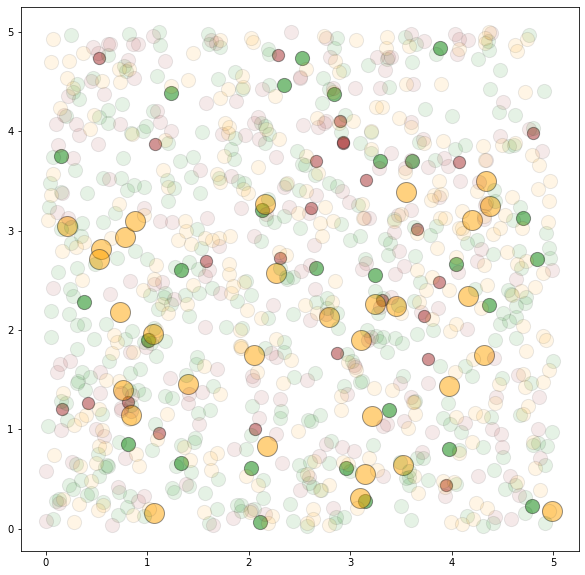

Total yield in Calories is 127.3.
---



In [5]:
# second agent: biased search in weight space

import gym
import numpy as np

# global parameters for trials
testbed = Field()
best_weights = np.random.dirichlet(np.ones(4))
best_yield = 0
yield_history = []
sow_limit = 10
num_trials = 100

# for storing subplots
subplots = []


# does a random walk in weight space and keeps any step that improves yield
for i in range(num_trials):
    
    # initialize trial
    observation = testbed.reset()
    done = False
    count = 0
    
    # calculate step vector for random walk
    epsilon = np.random.random(1) / 20
    delta = epsilon * np.random.permutation([1, 1, -1, -1])
    
    while not done:
        count += 1
        
        # ensure step won't take agent outside of weight space
        while True in ((best_weights + delta) < 0):
            epsilon = np.random.random(1) / 20
            delta = epsilon * np.random.permutation([1, 1, -1, -1])
        weights = best_weights + delta
        action = [np.random.choice(4, p=weights) for i in range(sow_limit)]
        observation, reward, done, _ = testbed.step(action)
        
        if done:
            yield_history.append(round(reward))
            if reward > best_yield:
                best_yield = reward
                best_weights = weights
                
    if i % 20 == 0:
        print("Results after {} trials:".format(i))
        subplot = testbed.render()
        # subplots.append(subplot) # attempting to get a six-in-one figure


# run a final trial using the best weights discovered
observation = testbed.reset()
done = False
while not done:
    weights = best_weights
    action = [np.random.choice(4, p=best_weights) for i in range(sow_limit)]
    observation, reward, done, _ = testbed.step(action)
    

# show results
print("Results after {} trials:".format(num_trials))
#print("Yield history is: ", yield_history)
#print(best_yield)
print("Best weights discovered are: \n\tsow maize \t{} \n\tsow bean \t{} \n\tsow squash \t{} \
       \n\twait \t\t{}".format(best_weights[0], best_weights[1], best_weights[2], best_weights[3]))
            
testbed.render()
#print(subplots)


[0.6534229  0.047415   0.02149243 0.27766967]


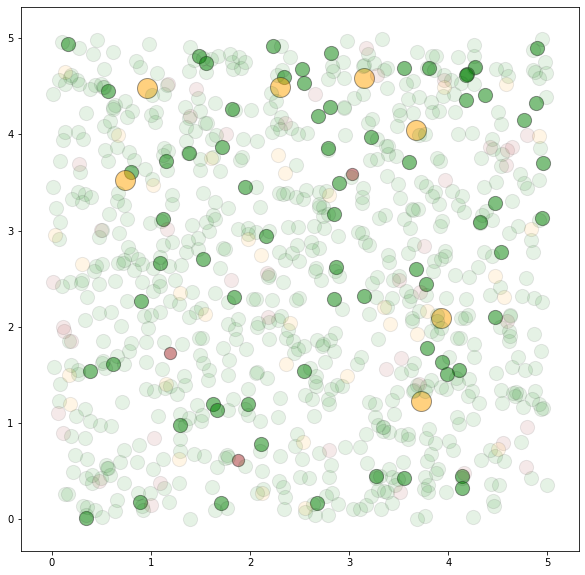

Total yield in Calories is 82.0.
---



In [4]:
# simple agent: takes random sample of weight space to arrive at best weights

import gym
import numpy as np

testbed = Field()
best_weights = np.zeros(4)
best_yield = 0
yield_history = []
sow_limit = 10


# run the trials where each set of weights produces a yield
for i in range(100):
    observation = testbed.reset()
    done = False
    count = 0
    while not done:
        count += 1
        weights = np.random.dirichlet(np.ones(4))
        action = [np.random.choice(4, p=weights) for i in range(sow_limit)]
        observation, reward, done, _ = testbed.step(action)
        
        if done:
            yield_history.append(round(reward))
            if reward > best_yield:
                best_yield = reward
                best_weights = weights


# run a final trial using the best weights discovered
observation = testbed.reset()
done = False
while not done:
    weights = best_weights
    action = [np.random.choice(4, p=best_weights) for i in range(sow_limit)]
    observation, reward, done, _ = testbed.step(action)
    

# show results
#print(yield_history)
#print(best_yield)
print(best_weights)
            
testbed.render()


In [1]:
# trying to write time into the env appropriately

import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import error, spaces, utils
from gym.utils import seeding
from enum import Enum

class Plant:
    def __init__(self, species, maturity=110):
        self.species = species
        self.maturity = maturity
        self.age = 0
        
    def __repr__(self):
        return "{}".format(self.species)
    

class Field(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, size=5, sow_limit=200, season=120, calendar=0):
        # parameters for overall field character
        self.size = size
        self.sow_limit = sow_limit
        self.season = season
        self.calendar = calendar
        
        # constants for computing end-of-season reward---distances represent meters
        self.crowding_dist = .02
        self.maize_maize_dist = .1
        self.bean_support_dist = .1
        self.crowding_penalty = .1
        self.maize_maize_penalty = .9
        self.bean_support_bonus = .6
        
        # OpenAI action and observation space specifications
        self.action_space = spaces.Discrete(4)
        ### self.observation_space = spaces.???
        
        # field is initialized by calling reset()
        self.field = None
        
    def step(self, action):
        # sow plants (or wait) depending on actions chosen
        # action is an array of n choices; value of n specified in agent code sow_limit
        # could be cleaned up with plants as an enumeration?
        
        for choice in action:
            if choice == 0:
                self.field = np.append(self.field, [[self.size * np.random.random(), 
                                             self.size * np.random.random(), 
                                             Plant('Maize')]], axis=0)
            elif choice == 1:
                self.field = np.append(self.field, [[self.size * np.random.random(), 
                                             self.size * np.random.random(), 
                                             Plant('Bean')]], axis=0)
            elif choice == 2:
                self.field = np.append(self.field, [[self.size * np.random.random(), 
                                             self.size * np.random.random(), 
                                             Plant('Squash')]], axis=0)
            # when choice == 3, nothing is done (agent waits)   
            
        
        # increment timekeeping
        self.calendar +=1
        for plant in self.field:
            plant[2].age += 1
            
        # set end-of-episode conditions
        done = self.calendar == self.season
            
        # rewards are sparse
        if not done:
            reward = 0
        else:
            reward = self.get_reward()
            
        # observation returned is pair of (field state, day of season)
        return [self.field, self.calendar], reward, done, {}
    
    def reset(self):
        # field is initialized with one random corn plant in order to make sowing (by np.append) work
        self.field = np.array([[self.size * np.random.random(), 
                                self.size * np.random.random(), 
                                Plant('Maize')]])
        # timekeeping is reset
        self.calendar = 0
        
    def render(self, mode='human'):
        # initialize plant type arrays so that pyplot won't break if any is empty
        maize = np.array([[None, None]])
        bean = np.array([[None, None]])
        squash = np.array([[None, None]])
        maize_imm = np.array([[None, None]])
        bean_imm = np.array([[None, None]])
        squash_imm = np.array([[None, None]])
        
        # replace initial arrays with coordinates for each plant type
        maize = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Maize' and row[2].age >= row[2].maturity])
        bean = np.array([row for row in self.field 
                            if row[2].__repr__() == 'Bean' and row[2].age >= row[2].maturity])
        squash = np.array([row for row in self.field 
                              if row[2].__repr__() == 'Squash' and row[2].age >= row[2].maturity])
        maize_imm = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Maize' and row[2].age < row[2].maturity])
        bean_imm = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Bean' and row[2].age < row[2].maturity])
        squash_imm = np.array([row for row in self.field 
                             if row[2].__repr__() == 'Squash' and row[2].age < row[2].maturity])
        
        # plot the field
        plt.figure(figsize=(10, 10))
        plt.scatter(maize[:,0], maize[:,1], c='green', s=200, marker = 'o', alpha=.5, edgecolor='#303030')
        plt.scatter(bean[:,0], bean[:,1], c='brown', s=150, marker = 'o', alpha=.5, edgecolor='#303030')
        plt.scatter(squash[:,0], squash[:,1], c='orange', s=400, marker = 'o', alpha=.5, edgecolor='#303030')
        plt.scatter(maize_imm[:,0], maize_imm[:,1], c='green', s=200, marker = 'o', alpha=.1, edgecolor='#303030')
        plt.scatter(bean_imm[:,0], bean_imm[:,1], c='brown', s=200, marker = 'o', alpha=.1, edgecolor='#303030')
        plt.scatter(squash_imm[:,0], squash_imm[:,1], c='orange', s=200, marker = 'o', alpha=.1, edgecolor='#303030')

        plt.show()
        
        print("Total yield in Calories is {}.\n---\n".format(round(reward, 1)))
    
    def close(self):
        # unneeded right now? AFAICT this is only used to shut down realtime movie visualizations
        pass
    
    def get_reward(self):
        # array of plant coordinates for computing distances
        xy_array = np.array([[row[0], row[1]] for row in self.field])

        # distances[m,n] is distance from mth to nth plant in field
        distances = np.linalg.norm(xy_array - xy_array[:,None], axis=-1)
        
        reward = 0
        i = 0
        
        while i < len(self.field):
            
            # immature plants yield nothing
            if self.field[i,2].age < self.field[i,2].maturity:
                reward += 0
                
            # mature plants yield according to species and plant-plant interactions
            elif self.field[i,2].__repr__() == 'Maize':
                cal = 1
                j = 0
                while j < len(distances[0]):
                    if (self.field[j,2].__repr__() == 'Bean' 
                            and distances[i,j] < self.bean_support_dist):
                        cal += self.bean_support_bonus
                    if (self.field[j,2].__repr__() == 'Maize' 
                            and i !=j 
                            and distances[i,j] < self.maize_maize_dist):
                        cal *= self.maize_maize_penalty
                    if 0 < distances[i,j] < self.crowding_dist:
                        cal *= self.crowding_penalty
                    j += 1
                reward += cal
            elif self.field[i,2].__repr__() == 'Bean':
                reward += .25
            elif self.field[i,2].__repr__() == 'Squash':
                reward += 3
            i += 1        
        return reward


Results after 0 trials:
Current sow limit: 


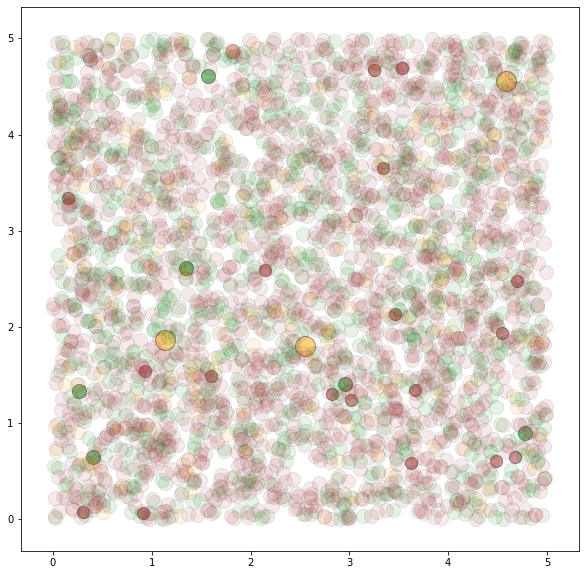

Total yield in Calories is 27.5.
---



In [ ]:
# third agent: biased search in weight space that can observe time
# OR MAYBE just try to write a new agent that not only adjusts weights but also sow limit

import gym
import numpy as np

# global parameters for episodes
testbed = Field()
best_weights = np.random.dirichlet(np.ones(4))
best_yield = 0
yield_history = []
sow_limit = 10
num_trials = 100

# for storing subplots
subplots = []


# does a random walk in weight+sow_limit space and keeps any step that improves yield
for i in range(num_trials):
    
    # initialize trial
    observation = testbed.reset()
    done = False
    count = 0
    
    # calculate step vector for random walk
    epsilon = np.random.random(1) / 20
    delta = epsilon * np.random.permutation([1, 1, -1, -1])
    
    # calculate step for sow_limit walk
    sigma = np.random.randint(-2, 3)
    
    while not done:
        count += 1
        
        # ensure step won't take agent outside of weight space
        while True in ((best_weights + delta) < 0):
            epsilon = np.random.random(1) / 20
            delta = epsilon * np.random.permutation([1, 1, -1, -1])
            
        # ensure step won't take sow_limit below 0
        while sow_limit + sigma < 0:
            sigma = np.random.randint(-2, 3)
        
        weights = best_weights + delta
        sow_limit += sigma
        action = [np.random.choice(4, p=weights) for i in range(sow_limit)]
        observation, reward, done, _ = testbed.step(action)
        
        if done:
            yield_history.append(round(reward))
            if reward > best_yield:
                best_yield = reward
                best_weights = weights
                
    if i % 20 == 0:
        print("Results after {} trials:".format(i))
        print("Current sow limit: ".format(sow_limit))
        subplot = testbed.render()
        # subplots.append(subplot) # attempting to get a six-in-one figure


# run a final trial using the best weights discovered
observation = testbed.reset()
done = False
while not done:
    weights = best_weights
    action = [np.random.choice(4, p=best_weights) for i in range(sow_limit)]
    observation, reward, done, _ = testbed.step(action)
    

# show results
print("Results after {} trials:".format(num_trials))
#print("Yield history is: ", yield_history)
#print(best_yield)
print("Best weights discovered are: \n\tsow maize \t{} \n\tsow bean \t{} \n\tsow squash \t{} \
       \n\twait \t\t{}".format(best_weights[0], best_weights[1], best_weights[2], best_weights[3]))
print("Best sow_limit discovered is {}.".format(sow_limit))
            
testbed.render()
#print(subplots)
